# Imports & Load Data

In [ ]:
import numpy as np
import os
import glob
import shutil
import cv2
import matplotlib.pyplot as plt
import random
from typing import List, Tuple

In [ ]:
from google.colab import userdata

os.environ['WANDB_DISABLED'] = 'true'
roboflow_api = userdata.get('ROBOFLOW')

In [ ]:
!pip install -q ultralytics roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 989.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.7/863.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 57.0 MB/s eta 0:00:00


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key=roboflow_api)
project = rf.workspace("brad-dwyer").project("pothole-voxrl")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.72, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Pothole-1 in yolov8:: 100%|██████████| 1342/1342 [00:00<00:00, 2147.37it/s]


In [ ]:
DATA_PATH = '/content/Pothole-1'
YAML_PATH = os.path.join(DATA_PATH, 'data.yaml')
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH =  os.path.join(DATA_PATH, 'test')
VAL_PATH =   os.path.join(DATA_PATH, 'valid')

### Visualizing Dataset

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
def yolo2bbox(bboxes: List[float])->tuple[float]:
  """
  Convert bounding boxes from YOLO format to standard bounding box format.

  Args:
      bboxes (tuple or list of float): A tuple or list containing four elements representing the bounding box in YOLO format.
          - bboxes[0] (float): The x-coordinate of the center of the bounding box (normalized).
          - bboxes[1] (float): The y-coordinate of the center of the bounding box (normalized).
          - bboxes[2] (float): The width of the bounding box (normalized).
          - bboxes[3] (float): The height of the bounding box (normalized).

  Returns:
      tuple of float: A tuple representing the bounding box in standard format (xmin, ymin, xmax, ymax).
          - xmin (float): The x-coordinate of the bottom-left corner of the bounding box.
          - ymin (float): The y-coordinate of the bottom-left corner of the bounding box.
          - xmax (float): The x-coordinate of the top-right corner of the bounding box.
          - ymax (float): The y-coordinate of the top-right corner of the bounding box.
  """
  xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
  xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
  return xmin, ymin, xmax, ymax

def plot_bboxes(img: np.ndarray, bboxes: List[List[float]], labels: List[bool]=None)->np.ndarray:
  """
  Plot bounding boxes on an image with optional labels.

  Args:
      img (numpy.ndarray): The image on which to draw the bounding boxes.
          Should be a NumPy array with shape (H, W, C), where H is the height, W is the width, and C is the number of color channels (usually 3 for RGB).
      bboxes (list of tuples or lists of float): A list containing bounding boxes in YOLO format.
          Each bounding box is represented by a tuple or list with four elements:
          - x_center (float): The x-coordinate of the center of the bounding box (normalized).
          - y_center (float): The y-coordinate of the center of the bounding box (normalized).
          - width (float): The width of the bounding box (normalized).
          - height (float): The height of the bounding box (normalized).
      labels (list of int, optional): A list of labels corresponding to each bounding box. If provided, the label is used to determine the color of the bounding box.
          - 0 (int): Will be drawn in yellow.
          - 1 (int): Will be drawn in magenta.
          If None, default colors will be used.

  Returns:
      numpy.ndarray: The image with bounding boxes drawn on it. The image is returned in the same format as the input.
  """
  h, w, _ = img.shape
  if len(set(labels))<3:
    colors= [(i, j, k) for i in (0, 255) for j in (0, 255) for k in (0, 255) if not(i==j and j==k)]
  for box_num, box in enumerate(bboxes):
    x1, y1, x2, y2 = yolo2bbox(box)
    #Denormalizing the coordinates
    xmin = int(x1*w)
    ymin = int(y1*h)
    xmax = int(x2*w)
    ymax = int(y2*h)

    thickness = max(2, int(w/275))
    if len(set(labels))<3:
      color = colors[box_num%len(colors)]
    elif labels[box_num] == 0:
      color = (255, 255, 0)
    else:
      color = (200, 0, 255)
    cv2.rectangle(
        img,
        (xmin, ymin), (xmax, ymax),
        color = color,
        thickness = thickness
    )
  return img

In [ ]:
def plot(images_path: str, labels_path: str, cols: int=4, rows: int= 3)->None:
  """
  Display a grid of images with their corresponding bounding boxes and labels.

  Args:
      images_path (str): Path to the directory containing images.
      labels_path (str): Path to the directory containing label files (one per image).
      cols (int, optional): Number of columns in the grid. Default is 4.
      rows (int, optional): Number of rows in the grid. Default is 3.

  Returns:
      None
  """
  all_images = os.listdir(images_path)
  all_images.sort()

  num_images = len(all_images)

  fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(20,20))
  for i in range(cols*rows):
    j = np.random.randint(0, num_images-1)
    image_path = os.path.join(images_path, all_images[j])
    label_path = os.path.join(labels_path, all_images[j][:-4]+'.txt')

    with open(label_path, 'r') as f:
      label_lines = f.readlines()
      annotations = [(list(map(float, annotation.split(' ')))) for annotation in label_lines]
      bboxes = []
      labels = []
      for annotation in annotations:
        labels.append(annotation[0])
        bboxes.append(annotation[1:])

    image = cv2.imread(image_path)
    res_image = plot_bboxes(image, bboxes, labels)
    ax.flatten()[i].imshow(image)

  plt.tight_layout()
  plt.show()

plot(os.path.join(TRAIN_PATH, 'images'), os.path.join(TRAIN_PATH, 'labels'), 3)

Output hidden; open in https://colab.research.google.com to view.

# Train YOLOv8 Nano

In [ ]:
from ultralytics import YOLO

#load model
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 307MB/s]


### Specify YAML file

In [ ]:
yaml_content = f"""
names:
- pothole
nc: 1
roboflow:
  license: ODbL v1.0
  project: pothole-voxrl
  url: https://universe.roboflow.com/brad-dwyer/pothole-voxrl/dataset/1
  version: 1
  workspace: brad-dwyer
test: {TEST_PATH}
train: {TRAIN_PATH}
val: {VAL_PATH}
"""

with open(YAML_PATH, 'w') as file:
    file.write(yaml_content)

### Training Model

In [ ]:
#training_parameters
EPOCHS = 10
BATCH = 8
IMG_SIZE = 1280
RESULTS_PATH = 'yolov8n_v8_50e'

#train
results = model.train(
    data = YAML_PATH,
    imgsz = IMG_SIZE,
    epochs = EPOCHS,
    batch = BATCH,
    name = RESULTS_PATH
)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Pothole-1/data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

100%|██████████| 755k/755k [00:00<00:00, 88.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/Pothole-1/train/labels... 465 images, 0 backgrounds, 0 corrupt: 100%|██████████| 465/465 [00:00<00:00, 1993.70it/s]

train: New cache created: /content/Pothole-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/Pothole-1/valid/labels... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<00:00, 1121.42it/s]

val: New cache created: /content/Pothole-1/valid/labels.cache


Plotting labels to runs/detect/yolov8n_v8_50e2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_v8_50e2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.75G       1.94      5.172      2.083          2       1280: 100%|██████████| 59/59 [00:37<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

                   all        133        330      0.438      0.097      0.147     0.0609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.29G      1.733      4.029      1.907          3       1280: 100%|██████████| 59/59 [00:29<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.50it/s]

                   all        133        330      0.419      0.218      0.218     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.33G      1.737      3.591      1.913         17       1280: 100%|██████████| 59/59 [00:29<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


                   all        133        330      0.382       0.37      0.295      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.29G      1.735       3.15      1.876          1       1280: 100%|██████████| 59/59 [00:27<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        133        330      0.471      0.321      0.323      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.29G      1.708      2.902      1.856          2       1280: 100%|██████████| 59/59 [00:28<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]

                   all        133        330       0.41        0.3      0.266      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.33G      1.663      2.684      1.792          5       1280: 100%|██████████| 59/59 [00:28<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

                   all        133        330      0.608       0.38      0.452       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.29G      1.588      2.417      1.729          2       1280: 100%|██████████| 59/59 [00:28<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]

                   all        133        330      0.641      0.454      0.525      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.33G      1.522      2.242      1.668          3       1280: 100%|██████████| 59/59 [00:28<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]

                   all        133        330      0.664      0.485      0.567      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.33G      1.456      2.116      1.619          1       1280: 100%|██████████| 59/59 [00:27<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]

                   all        133        330      0.619      0.567       0.61      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.32G      1.444      2.043       1.57          1       1280: 100%|██████████| 59/59 [00:28<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]

                   all        133        330      0.685      0.521      0.616      0.353



10 epochs completed in 0.104 hours.
Optimizer stripped from runs/detect/yolov8n_v8_50e2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_v8_50e2/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_v8_50e2/weights/best.pt...
Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


                   all        133        330      0.688      0.521      0.616      0.352
Speed: 1.2ms preprocess, 8.7ms inference, 0.0ms loss, 8.9ms postprocess per image
Results saved to runs/detect/yolov8n_v8_50e2


# Validation and Benchmark

### Validation Results

In [ ]:
def visualize_yolo_runs(res_dir, num_samples=4):
  """
  Display a grid of random images from a directory.

  Args:
      res_dir (str): Directory containing images.
      num_samples (int, optional): Number of images to display. Default is 4.

  Returns:
      None
  """
  plt.figure(figsize=(20, 20))
  image_names = glob.glob(os.path.join(res_dir, '*.jpg'))
  random.shuffle(image_names)
  for i, image_name in enumerate(image_names):
    image = plt.imread(image_name)
    plt.subplot(2, 2, i+1)
    plt.imshow(image)
    plt.axis("off")
    if i==num_samples-1:
      break
  plt.tight_layout()
  plt.show()

def visualize_yolo_metrics(res_dir: str)->None:
  """
  Display YOLO metrics from PNG files in the runs directory.

  Args:
      res_dir (str): Directory containing the metric images.

  Returns:
      None
  """
  metrics = ['F1_curve', 'PR_curve', 'P_curve', 'R_curve']
  fig, ax = plt.subplots(ncols=2, nrows=(len(metrics)+1)//2, figsize=(10, 8))
  for i, metric in enumerate(metrics):
    try:
      img_path = os.path.join(res_dir, metric+'.png')
      img = cv2.imread(img_path)
      ax.flatten()[i].imshow(img)
      ax.flatten()[i].axis('off')
    except:
      print(f'Error displaying f{metric}')
  plt.tight_layout()
  plt.show()

visualize_yolo_runs(os.path.join('/content/runs/detect', RESULTS_PATH))

Output hidden; open in https://colab.research.google.com to view.

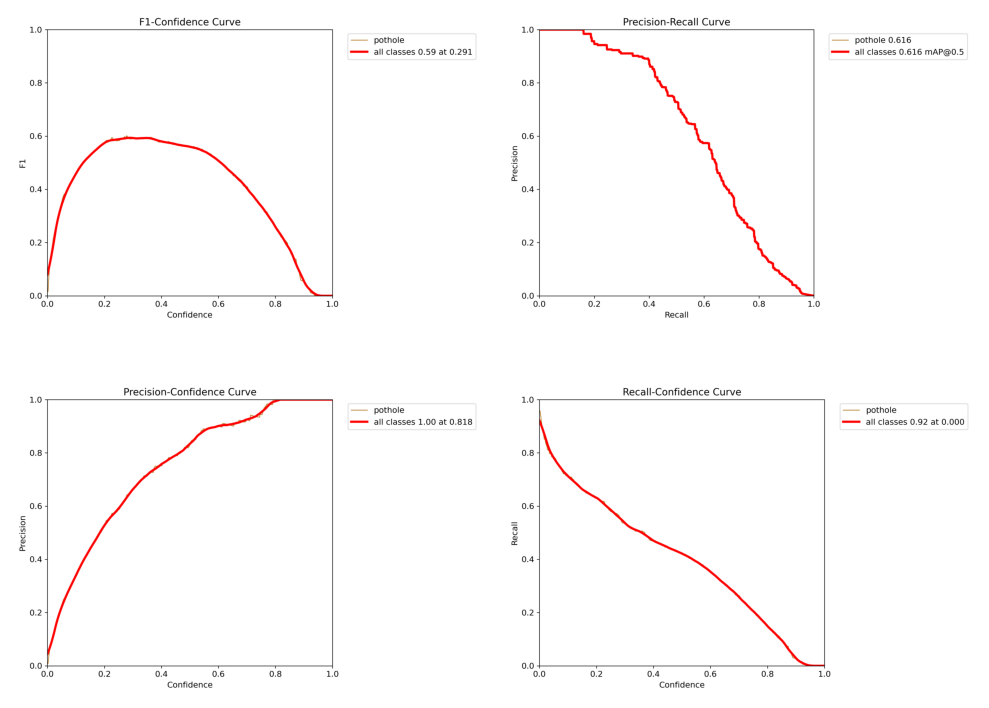

In [ ]:
visualize_yolo_metrics(os.path.join('/content/runs/detect', RESULTS_PATH))

### Inference Pipeline

In [ ]:
def visualize_inference_pipeline(path: str=None, img=None, verbose=True):
  """
  Visualize the results of an inference pipeline by displaying bounding boxes on an image.

  Args:
      path (str, optional): Path to the image file. If provided, the image will be loaded from this path.
      img (numpy.ndarray, optional): Image array. If provided, this image will be used directly.
      verbose (bool, optional): Whether to print verbose output during inference. Default is True.

  Returns:
      None: Displays the image with bounding boxes drawn on it.
  """
  if path is None and img is None:
    assert ValueError("Either img_path or img must be provided")
    return None
  if img is None:
    outputs = model(path, verbose=verbose)[0]
    img = cv2.imread(path)
  else:
    outputs = model(img, verbose=verbose)[0]
  res = plot_bboxes(img, [box[0].xywhn.tolist()[0] for box in outputs.boxes], outputs.boxes.cls)
  return img

### Inference on real images


image 1/1 /content/images (3).jpeg: 864x1280 1 pothole, 14.9ms
Speed: 9.2ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 864, 1280)


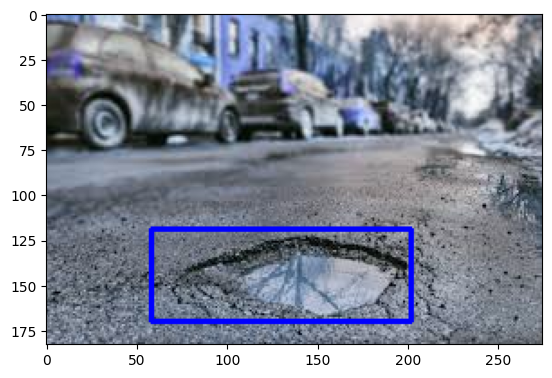

In [ ]:
op_img = visualize_inference_pipeline("/content/images (3).jpeg")
plt.imshow(op_img)

### Benchmark on Val Set

In [ ]:
metrics = model.val()

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/Pothole-1/valid/labels.cache... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.26it/s]


                   all        133        330      0.697      0.518      0.617      0.353
Speed: 1.6ms preprocess, 35.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/yolov8n_v8_50e22


In [ ]:
metrics.results_dict

{'metrics/precision(B)': 0.6973277419137093,
 'metrics/recall(B)': 0.5181818181818182,
 'metrics/mAP50(B)': 0.6166083679374964,
 'metrics/mAP50-95(B)': 0.35271803066786844,
 'fitness': 0.3791070643948312}

### Benchmark on Test set

In [ ]:
yaml_content = f"""
names:
- pothole
nc: 1
roboflow:
  license: ODbL v1.0
  project: pothole-voxrl
  url: https://universe.roboflow.com/brad-dwyer/pothole-voxrl/dataset/1
  version: 1
  workspace: brad-dwyer
test: {TEST_PATH}
train: {TRAIN_PATH}
val: {TEST_PATH}
"""
with open(YAML_PATH, 'w') as file:
    file.write(yaml_content)

In [ ]:
metrics = model.val(data=YAML_PATH)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/Pothole-1/test/labels... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 1407.76it/s]

val: New cache created: /content/Pothole-1/test/labels.cache



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.78it/s]


                   all         67        154      0.678      0.578      0.626      0.352
Speed: 1.6ms preprocess, 28.6ms inference, 0.0ms loss, 8.5ms postprocess per image
Results saved to runs/detect/yolov8n_v8_50e23


In [ ]:
metrics.results_dict

{'metrics/precision(B)': 0.6781034244439731,
 'metrics/recall(B)': 0.577922077922078,
 'metrics/mAP50(B)': 0.6261096689169088,
 'metrics/mAP50-95(B)': 0.35249241529690856,
 'fitness': 0.3798541406589086}